### This notebook plays around with node degrees and looks at the impact of systematically deleting SC ...

In [1]:
# Importage
import warnings
warnings.filterwarnings('ignore')

# os stuff
import os
import sys

import nibabel as nib
from nilearn.plotting import plot_surf, plot_surf_stat_map, plot_roi, plot_anat, plot_surf_roi
from nilearn.image import index_img

import seaborn as sns

# whobpyt stuff
import whobpyt
from whobpyt.data.dataload import dataloader
# from whobpyt.models.jansen_rit import RNNJANSEN
from whobpyt.models.wong_wang import RNNRWW
from whobpyt.datatypes.modelparameters import ParamsModel
from whobpyt.optimization.modelfitting import Model_fitting

# array and pd stuff
import numpy as np
import pandas as pd

# viz stuff
import matplotlib.pyplot as plt

In [2]:
from collections import Counter

In [3]:
import pickle

In [4]:
Davide_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Neg_Corrs_Jam_Session_June_2022/Davide_HCP_Data_Matrix'

ShreyVB_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Neg_Corrs_Jam_Session_June_2022'

Wts_Path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Improved_WWD_HCP_model_runs/Sub_Specific_SC_Wts_2'

pconn_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Shrey_SS_parcellated_Func_Conns_II/'

# _sub_list = [200614, 199958, 177746, 164131, 141826, 130619, 127933, 116726, 100307, 100206]
# sub_list = list(reversed(_sub_list))

parcs = np.arange(0,200,1)

In [5]:
# %%
# define options for wong-wang model
node_size = 200
mask = np.tril_indices(node_size, -1)
num_epoches = 20 #50
batch_size = 20
step_size = 0.05
input_size = 2
tr = 2.0
repeat_size = 5

In [6]:
sub_list_1 = [100610, 103111, 118528, 139637, 144428, 158136, 182739, 102513, 102816, 107321, 107422, 108525, 112112, 121618, 129331]
sub_list_2 = [129634, 132118, 133625, 133827, 134829, 137936, 153227, 154936, 156334, 173435]
sub_list = np.concatenate((sub_list_1, sub_list_2))
sub_list.sort()

In [7]:
parcs = np.arange(0,200,1)

mask = np.tril_indices(len(parcs), -1)

# Labels
_label_file =  '/external/rprshnas01/kcni/hharita/Code/shreyVB/scratch/Schaefer_200_labels.txt'

f = open(_label_file, "r")
q = f.read()
q = q.rsplit('\n')
# del q[-32:]
labels = q.copy()
labels = np.array(labels)
labels = labels[parcs]


In [18]:
 sub_id = 100307
_gg = np.loadtxt(Wts_Path + "/{0}_SC_wts.txt".format(sub_id))

# Structural Connectivity
HCP_SC1 = _gg[parcs][:,parcs] 
HCP_SC1 = HCP_SC1 + HCP_SC1.T # --> Symmetric
pre_laplachian_HCP_SC = HCP_SC1.copy()

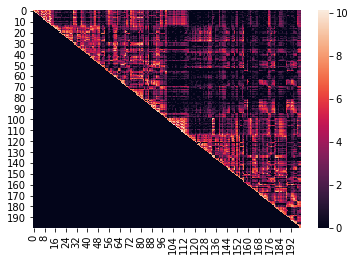

In [23]:
fig, ax = plt.subplots()
sns.heatmap(np.log1p(_gg))

In [8]:
def load_wts(sub_id):
    
    _gg = np.loadtxt(Wts_Path + "/{0}_SC_wts.txt".format(sub_id))

    # Structural Connectivity
    HCP_SC1 = _gg[parcs][:,parcs] 
    HCP_SC1 = HCP_SC1 + HCP_SC1.T # --> Symmetric
    pre_laplachian_HCP_SC = HCP_SC1.copy()

    # Laplachian!

    HCP_SC = -np.diag((pre_laplachian_HCP_SC/np.linalg.norm(pre_laplachian_HCP_SC)).sum(0)) + pre_laplachian_HCP_SC/np.linalg.norm(pre_laplachian_HCP_SC)
    
    return pre_laplachian_HCP_SC, HCP_SC

In [9]:
%%time
all_subs_pre_lap_SC = []
all_subs_HCP_SC = []

for i in range(len(sub_list)):
    pre_lap_SC, ss_SC = load_wts(sub_list[i])
    all_subs_pre_lap_SC.append(pre_lap_SC)
    all_subs_HCP_SC.append(ss_SC)

CPU times: user 970 ms, sys: 45.7 ms, total: 1.02 s
Wall time: 2.23 s


In [10]:
pconn_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Shrey_SS_parcellated_Func_Conns_II/'

In [11]:
def load_FC(sub_id):
    
    pconn1LR = pconn_path + '{0}_rfMRI_REST1_RL_Schaefer200_cifti_parcellated.ptseries.nii'.format(sub_id)
#     pconn1RL = pconn_path + '{0}_rfMRI_REST1_RL_Schaefer200_cifti_correlated.pconn.nii'.format(sub_id)
#     pconn2LR = pconn_path + '{0}_rfMRI_REST2_LR_Schaefer200_cifti_correlated.pconn.nii'.format(sub_id)
#     pconn2RL = pconn_path + '{0}_rfMRI_REST2_RL_Schaefer200_cifti_correlated.pconn.nii'.format(sub_id)
    
    _pconn_img1LR = nib.load(pconn1LR)
    _pconn_dat1LR = _pconn_img1LR.get_data()
    _pconn_dat1LR = _pconn_dat1LR/1

#     _pconn_img1RL = nib.load(pconn1RL)
#     _pconn_dat1RL = _pconn_img1RL.get_data()
#     _pconn_dat1RL = _pconn_dat1RL/1

#     _pconn_img2LR = nib.load(pconn2LR)
#     _pconn_dat2LR = _pconn_img2LR.get_data()
#     _pconn_dat2LR = _pconn_dat2LR/1

#     _pconn_img2RL = nib.load(pconn2RL)
#     _pconn_dat2RL = _pconn_img2RL.get_data()
#     _pconn_dat2RL = _pconn_dat2RL/1
    
#     _test_pconn = (_pconn_dat1LR + _pconn_dat1LR + _pconn_dat2LR + _pconn_dat2RL)/4
    
    return _pconn_dat1LR

In [12]:
%%time
all_subs_pconn1LR = []
# all_subs_pconn1RL = []
# all_subs_pconn2LR = []
# all_subs_pconn2RL = []
# all_subs_FC = []


for i in range(len(sub_list)):

    _1LR = load_FC(sub_list[i])
    all_subs_pconn1LR.append(_1LR)
#     all_subs_pconn1RL.append(_1RL)
#     all_subs_pconn2LR.append(_2LR)
#     all_subs_pconn2RL.append(_2RL)
#     all_subs_FC.append(avg_ss_pconn)

CPU times: user 7.67 s, sys: 70.8 ms, total: 7.74 s
Wall time: 8.92 s


In [13]:
data_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/WhoBPyT/HCP_200_parcs'

In [14]:
def open_pickles(sub_id):
    filename = data_path + '/Subj_{0}_fittingresults_stim_exp.pkl'.format(sub_id)
    with open(filename, 'rb') as f:
        g = pickle.load(f)
    
    outfilename = data_path + '/Subj_{0}_simEEG_stim_exp.pkl'.format(sub_id)
    with open(outfilename, 'rb') as f1:
        g1 = pickle.load(f1)
    
    return g, g1

In [15]:
%%time
all_subs_fittingresults = []
all_subs_simEEG = []
for i in range(len(sub_list)):
    ss_fittingresult, ss_simEEG = open_pickles(sub_list[i])
    all_subs_fittingresults.append(ss_fittingresult)
    all_subs_simEEG.append(ss_simEEG)

CPU times: user 7.06 s, sys: 30.8 s, total: 37.9 s
Wall time: 3min 9s


In [16]:
# 

### calculate the node degree of the fitted SC matrix

In [17]:
og_data_all_subs = all_subs_fittingresults.copy()

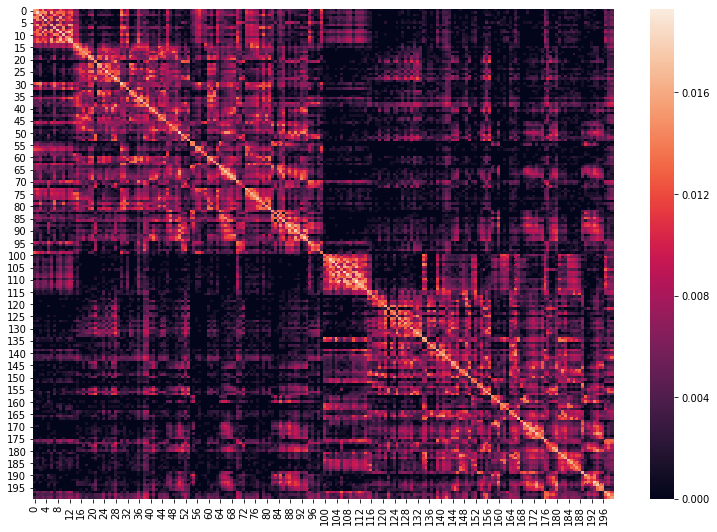

In [18]:
fig, ax = plt.subplots(figsize=(13,9))
sns.heatmap(og_data_all_subs[0].model.sc)

In [20]:
# model.gains_con is the modification/change to the original SC. 

# Here is a simpler way to understand this ...

# original_sc * model.gains_con = fitted_sc

In [21]:
fitted_sc3 = np.abs(og_data_all_subs[0].model.gains_con.detach().numpy())

In [22]:
sorted_pairs3 = []
node_degree_all_nodes3 = []
for i in range(len(fitted_sc3)):
    node_degree = np.sum(fitted_sc3[i])
    node_degree_all_nodes3.append(node_degree)
    

value_index_pairs3 = list(enumerate(node_degree_all_nodes3))

sorted_pairs3 = sorted(value_index_pairs3, key=lambda x: x[1], reverse=True)

In [23]:
sorted_pairs3

[(1, 744.8981),
 (86, 635.83563),
 (90, 598.05743),
 (165, 580.08887),
 (94, 579.8562),
 (88, 570.30664),
 (194, 549.0818),
 (198, 515.8624),
 (81, 513.554),
 (91, 503.42752),
 (96, 496.61115),
 (199, 490.90387),
 (85, 489.84583),
 (180, 471.98004),
 (98, 469.141),
 (63, 467.33966),
 (76, 467.33813),
 (166, 466.44727),
 (177, 465.73547),
 (183, 463.1754),
 (143, 462.91248),
 (38, 462.52097),
 (73, 458.8122),
 (92, 453.7123),
 (70, 452.46304),
 (65, 444.57617),
 (74, 441.7626),
 (175, 438.2654),
 (149, 436.6542),
 (39, 435.64716),
 (84, 435.1529),
 (93, 432.83298),
 (60, 430.84253),
 (66, 430.53613),
 (176, 429.3156),
 (142, 428.4815),
 (36, 426.31915),
 (170, 425.73264),
 (189, 424.68402),
 (79, 419.1161),
 (157, 413.947),
 (156, 413.78546),
 (82, 413.29123),
 (69, 411.88922),
 (28, 410.80856),
 (193, 408.1468),
 (77, 407.79776),
 (164, 406.10287),
 (141, 405.2643),
 (24, 397.25522),
 (52, 397.21326),
 (185, 396.7172),
 (51, 396.45166),
 (182, 396.12726),
 (127, 395.98218),
 (131, 392.

In [24]:
sorted_pairs3[0:10]

[(1, 744.8981),
 (86, 635.83563),
 (90, 598.05743),
 (165, 580.08887),
 (94, 579.8562),
 (88, 570.30664),
 (194, 549.0818),
 (198, 515.8624),
 (81, 513.554),
 (91, 503.42752)]

In [25]:
_df = pd.DataFrame(sorted_pairs3,columns=['Index','Node Degree'])
# _df.head()

idx_list = _df['Index'].tolist()

In [26]:
# first - make top 5 original sc rows = 0
# second - make top 5 model.gains_con = 0, this reverts the original sc to default value.

#### first - part 1: make top n original sc rows = 0

In [27]:
# make the first 100 model.gains_con sc rows = 0 ...
# based on the sorted model.gains_con (sorted_pairs3) 

In [28]:
_regions = idx_list[0:100]

In [29]:
_alternate_sc3 = og_data_all_subs[0].model.sc.copy()
_alternate_sc3[_regions,:] = 0

In [30]:
og_data_all_subs[0].model.sc = _alternate_sc3.copy()

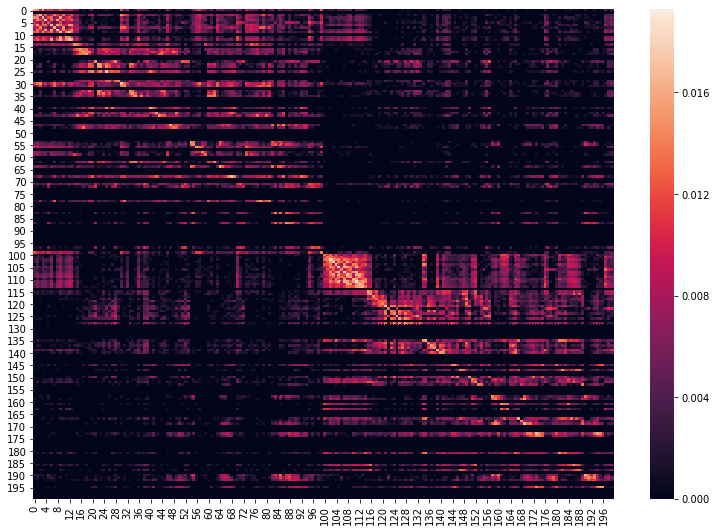

In [31]:
fig, ax = plt.subplots(figsize=(13,9))
sns.heatmap(og_data_all_subs[0].model.sc)

In [79]:
%%time

# run the model ...(test)
og_data_all_subs[0].test(20)

0.3707166823294086 cos_sim:  0.9899782666685573
CPU times: user 5min 14s, sys: 16.5 s, total: 5min 31s
Wall time: 5min 31s


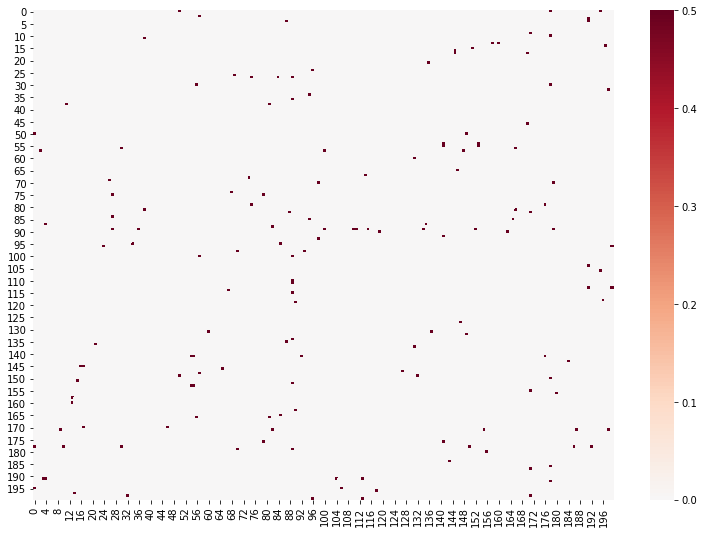

In [35]:
fig, ax = plt.subplots(figsize=(13,9))
sns.heatmap(np.corrcoef(og_data_all_subs[0].output_sim.bold_test)<-0.1,cmap='RdBu_r',center=0,vmax=0.5)

### for multiple subjects:

In [110]:
%%time

b = 25
og_data_all_subs = all_subs_fittingresults.copy()

for i in range(25):
    
    fitted_sc3 = np.abs(og_data_all_subs[i].model.gains_con.detach().numpy())
    
    value_index_pairs3 = []
    sorted_pairs3 = []
    node_degree_all_nodes3 = []
    for j in range(len(fitted_sc3)):
        node_degree = np.sum(fitted_sc3[j])
        node_degree_all_nodes3.append(node_degree)
    

    value_index_pairs3 = list(enumerate(node_degree_all_nodes3))

    sorted_pairs3 = sorted(value_index_pairs3, key=lambda x: x[1], reverse=True)
    
    _df = pd.DataFrame(sorted_pairs3,columns=['Index','Node Degree'])
    idx_list = _df['Index'].tolist()
    
    _regions = idx_list[0:100]
    
    _alternate_sc3 = og_data_all_subs[i].model.sc.copy()
    _alternate_sc3[_regions,:] = 0
    
    og_data_all_subs[i].model.sc = _alternate_sc3.copy()
    
    print("running model on test data for subj {0} of {1} ... \n".format(i+1,b))
    # run the model ...(test)
    og_data_all_subs[i].test(20)

running model on test data for subj 1 of 25 ... 

0.35294349192048563 cos_sim:  0.9900125260180794
running model on test data for subj 2 of 25 ... 

0.4795161626552463 cos_sim:  0.9836003163551638
running model on test data for subj 3 of 25 ... 

0.41666014288819503 cos_sim:  0.9880833340339795
running model on test data for subj 4 of 25 ... 

0.2962365631345774 cos_sim:  0.9929871190617336
running model on test data for subj 5 of 25 ... 

0.27366999285615995 cos_sim:  0.9891984959472712
running model on test data for subj 6 of 25 ... 

0.3881637322812137 cos_sim:  0.9915069287773047
running model on test data for subj 7 of 25 ... 

0.30338199349556644 cos_sim:  0.9899711828987117
running model on test data for subj 8 of 25 ... 

0.39914456726772113 cos_sim:  0.9841019200550488
running model on test data for subj 9 of 25 ... 

0.30960858921399736 cos_sim:  0.9886755762737188
running model on test data for subj 10 of 25 ... 

0.2318117394613974 cos_sim:  0.9898428185486193
running model

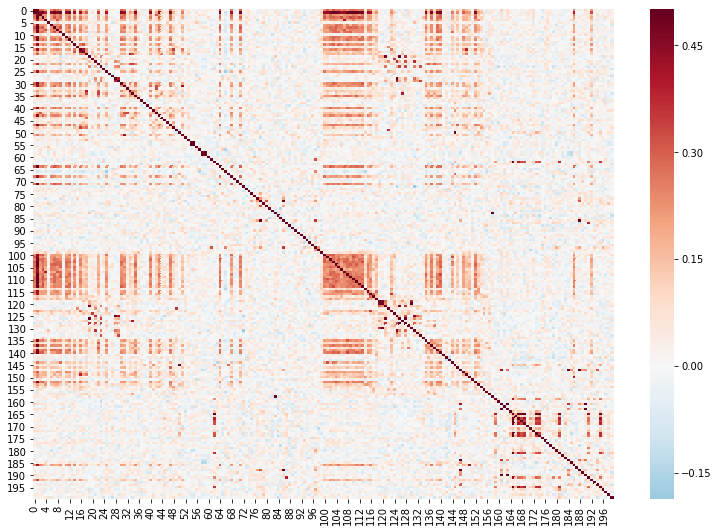

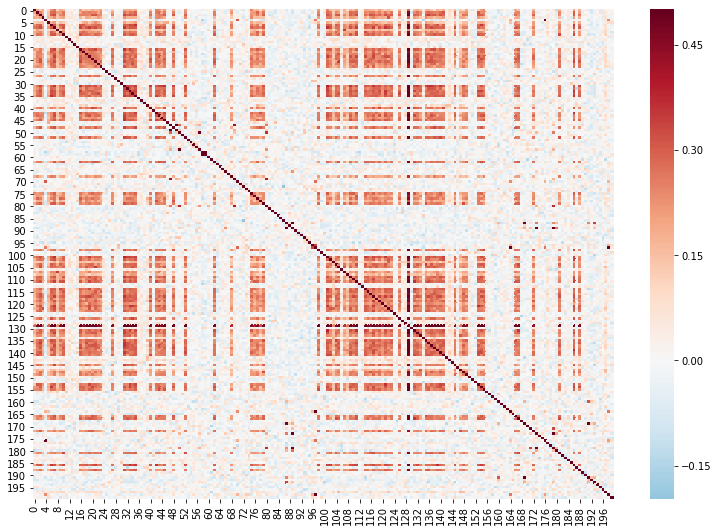

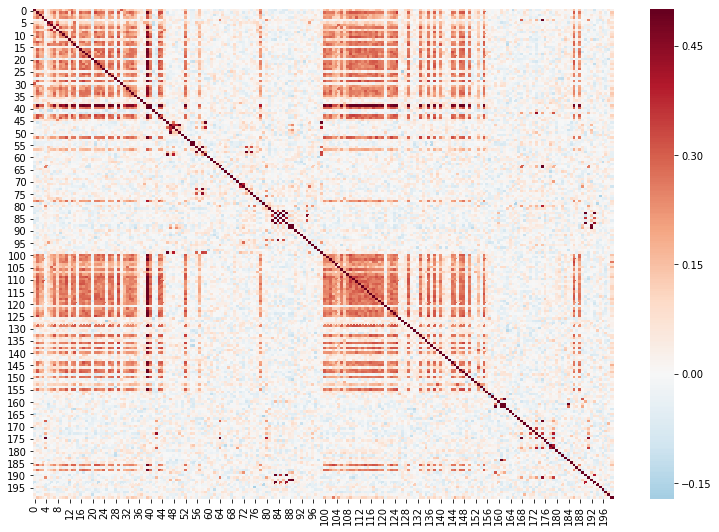

In [111]:
for i in range(3):
    fig, ax = plt.subplots(figsize=(13,9))
    sns.heatmap(np.corrcoef(og_data_all_subs[i].output_sim.bold_test),cmap='RdBu_r',center=0,vmax=0.5)

In [32]:
# for i in range(3):
#     fig, ax = plt.subplots(figsize=(13,9))
#     sns.heatmap(og_data_all_subs[i].model.sc_fitted.detach().numpy())#,cmap='RdBu_r',center=0,vmax=0.5)

In [33]:
# for i in range(3):
#     fig, ax = plt.subplots(figsize=(13,9))
#     sns.heatmap(og_data_all_subs[i].model.sc)

#### second - see which ntwx these regions belong to

In [153]:
%%time
all_subs_fittingresults = []
all_subs_simEEG = []
for i in range(len(sub_list)):
    ss_fittingresult, ss_simEEG = open_pickles(sub_list[i])
    all_subs_fittingresults.append(ss_fittingresult)
    all_subs_simEEG.append(ss_simEEG)

CPU times: user 6.93 s, sys: 30.7 s, total: 37.6 s
Wall time: 5min 34s


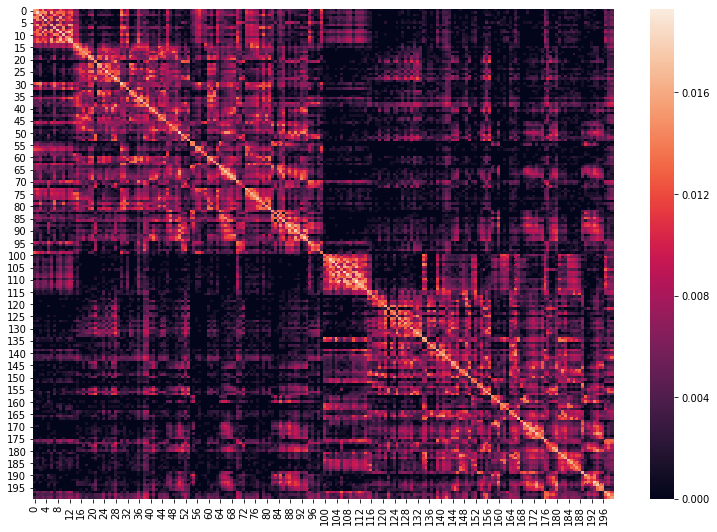

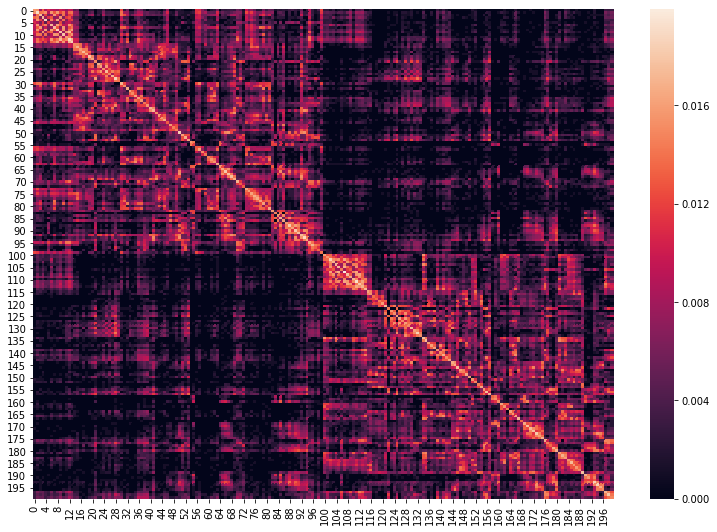

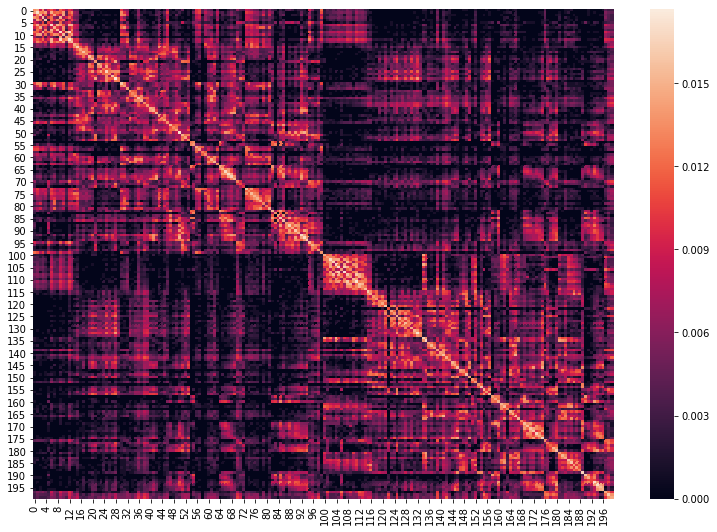

In [253]:
for i in range(3):
    fig, ax = plt.subplots(figsize=(13,9))
    sns.heatmap(og_data_all_subs2[i].model.sc)

In [19]:
lh_labels = labels[0:100]
rh_labels = labels[100:200]

In [20]:
og_data_all_subs2 = all_subs_fittingresults.copy()

all_subs_regions = []
for i in range(25):
    
    fitted_sc3 = np.abs(og_data_all_subs2[i].model.gains_con.detach().numpy())
    
    value_index_pairs3 = []
    sorted_pairs3 = []
    node_degree_all_nodes3 = []
    for j in range(len(fitted_sc3)):
        node_degree = np.sum(fitted_sc3[j])
        node_degree_all_nodes3.append(node_degree)
    

    value_index_pairs3 = list(enumerate(node_degree_all_nodes3))

    sorted_pairs3 = sorted(value_index_pairs3, key=lambda x: x[1], reverse=True)
    
    _df = pd.DataFrame(sorted_pairs3,columns=['Index','Node Degree'])
    idx_list = _df['Index'].tolist()
    
    _regions = idx_list[0:100]
    all_subs_regions.append(_regions)

In [21]:
# all_subs_regions[0][0:10]

In [22]:
# for i in range(3):
#     fig, ax = plt.subplots(figsize=(13,9))
#     sns.heatmap(og_data_all_subs2[i].model.sc)

##### Sort labels into 7 ntwx

In [23]:
ntwx_labels = ['Vis', 'SomMot', 'DAN', 'VAN', 'Limbic', 'FPN', 'DMN', 'TempPar']

In [24]:
lh_input_array = lh_labels.copy()

In [25]:
# Initialize the output lists
lh_vis_list = []
lh_som_mot_list = []
lh_dors_attn_list = []
lh_sal_vent_attn_list = []
lh_limbic_list = []
lh_cont_list = []
lh_default_list = []
lh_temp_par_list = []


# Iterate over each string in the input array
for string in lh_input_array:
    if 'Vis' in string:
        lh_vis_list.append(string)
    elif 'SomMot' in string:
        lh_som_mot_list.append(string)
    elif 'DorsAttn' in string:
        lh_dors_attn_list.append(string)
    elif 'SalVentAttn' in string:
        lh_sal_vent_attn_list.append(string)
    elif 'Limbic' in string:
        lh_limbic_list.append(string)
    elif 'Cont' in string:
        lh_cont_list.append(string)
    elif 'Default' in string:
        lh_default_list.append(string)
    elif 'TempPar' in string:
        lh_temp_par_list.append(string)

In [26]:
# print(len(lh_vis_list))
# print(len(lh_som_mot_list))
# print(len(lh_dors_attn_list))
# print(len(lh_sal_vent_attn_list))
# print(len(lh_limbic_list))
# print(len(lh_cont_list))
# print(len(lh_default_list))
# print(len(lh_temp_par_list))

In [27]:
lh_list = [0,12,16,11,11,6,18,24,2]
ll = np.cumsum(lh_list)
ll = ll.tolist()
ll
# print(np.cumsum(lh_list))  

[0, 12, 28, 39, 50, 56, 74, 98, 100]

In [28]:
labels[86]

'17Networks_LH_DefaultB_IPL_1'

In [29]:
rh_input_array = rh_labels.copy()

In [30]:
# Initialize the output lists
rh_vis_list = []
rh_som_mot_list = []
rh_dors_attn_list = []
rh_sal_vent_attn_list = []
rh_limbic_list = []
rh_cont_list = []
rh_default_list = []
rh_temp_par_list = []


# Iterate over each string in the input array
for string in rh_input_array:
    if 'Vis' in string:
        rh_vis_list.append(string)
    elif 'SomMot' in string:
        rh_som_mot_list.append(string)
    elif 'DorsAttn' in string:
        rh_dors_attn_list.append(string)
    elif 'SalVentAttn' in string:
        rh_sal_vent_attn_list.append(string)
    elif 'Limbic' in string:
        rh_limbic_list.append(string)
    elif 'Cont' in string:
        rh_cont_list.append(string)
    elif 'Default' in string:
        rh_default_list.append(string)
    elif 'TempPar' in string:
        rh_temp_par_list.append(string)

In [31]:
# print(len(rh_vis_list))
# print(len(rh_som_mot_list))
# print(len(rh_dors_attn_list))
# print(len(rh_sal_vent_attn_list))
# print(len(rh_limbic_list))
# print(len(rh_cont_list))
# print(len(rh_default_list))
# print(len(rh_temp_par_list))

In [32]:
rh_list = [0,12,18,11,15,8,19,13,4]
rr = np.cumsum(rh_list)
rr = rr.tolist()
rr
# print(np.cumsum(rh_list))  

[0, 12, 30, 41, 56, 64, 83, 96, 100]

In [34]:
# for i in range(len(all_subs_regions)):
#     for j in range(len(all_subs_regions))

In [35]:
_test_list = all_subs_regions[0].copy()

In [36]:
_test_list = all_subs_regions[0].copy()

In [37]:
ll

[0, 12, 28, 39, 50, 56, 74, 98, 100]

In [38]:
ntwx_labels = ['holder', 'Vis', 'SomMot', 'DAN', 'VAN', 'Limbic', 'FPN', 'DMN', 'TempPar']

In [39]:
_test_list  = all_subs_regions[0].copy()

In [40]:
sc_ntwx = []

for num in _test_list:
    if num < 100: 
        for i in range(len(ll)-1):
            if num >= ll[i] and num < ll[i+1]:
                sc_ntwx.append(ntwx_labels[i+1])
    elif num >= 100:
        gg = num - 100
        for i in range(len(rr)-1):
            if gg >= rr[i] and gg < rr[i+1]:
                sc_ntwx.append(ntwx_labels[i+1])

In [41]:
len(sc_ntwx)

100

In [42]:
# from collections import Counter

In [43]:
freq = Counter(sc_ntwx)

for label in ntwx_labels:
    if label == 'holder':
        continue
    count = freq[label]
    print(count)

2
10
10
15
8
23
27
5


#### for all subs 

In [44]:
%%time

all_subs_sc_counts = []

for q in range(25):
    
    _test_list = all_subs_regions[q].copy()
    ss_sc_ntwx = []
    
    for num in _test_list:
        if num < 100: 
            for i in range(len(ll)-1):
                if num >= ll[i] and num < ll[i+1]:
                    ss_sc_ntwx.append(ntwx_labels[i+1])
        elif num >= 100:
            gg = num - 100
            for i in range(len(rr)-1):
                if gg >= rr[i] and gg < rr[i+1]:
                    ss_sc_ntwx.append(ntwx_labels[i+1])
    
    ss_sc_counts = []
    freq = Counter(ss_sc_ntwx)
    for label in ntwx_labels:
        if label == 'holder':
            continue
        count = freq[label]
        ss_sc_counts.append(count)
    all_subs_sc_counts.append(ss_sc_counts)

CPU times: user 12.8 ms, sys: 195 µs, total: 13 ms
Wall time: 12.7 ms


In [45]:
type(all_subs_sc_counts)

list

In [49]:
all_subs_sc_counts[0:4]

[[2, 10, 10, 15, 8, 23, 27, 5],
 [7, 14, 8, 11, 9, 25, 21, 5],
 [2, 8, 12, 13, 7, 28, 25, 5],
 [10, 9, 9, 17, 6, 19, 24, 6]]

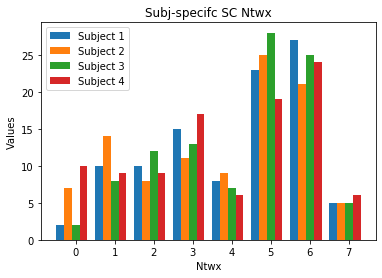

In [48]:
# sample_data = [[2, 10, 10, 15, 8, 23, 27, 5],
#                [7, 14, 8, 11, 9, 25, 21, 5],
#                [2, 8, 12, 13, 7, 28, 25, 5]]

sample_data = all_subs_sc_counts[0:4]

# Get the number of sublists (number of groups)
num_groups = len(sample_data)

# Get the number of elements in each sublist (number of bars in each group)
num_bars = len(sample_data[0])

# Create an array for the x positions of the bars
x_positions = np.arange(num_bars)

# Set the width of each bar
bar_width = 0.2

# Generate the vertical bar plot
fig, ax = plt.subplots()
for i in range(num_groups):
    ax.bar(x_positions + i * bar_width, sample_data[i], bar_width, label=f'Subject {i+1}')

# Set the x-axis labels
ax.set_xticks(x_positions + (bar_width * num_groups) / 2)
ax.set_xticklabels(x_positions)

# Set the y-axis label
ax.set_ylabel('Values')

# Set the x-axis label
ax.set_xlabel('Ntwx')

# Set the plot title
ax.set_title('Subj-specifc SC Ntwx')

# Add a legend
ax.legend()

# Show the plot
plt.show()

In [50]:
means = np.mean(all_subs_sc_counts, axis=0)


In [51]:
engaged_ntwx = means.copy()

In [52]:
means

array([ 5.8 , 11.48, 10.  , 13.16,  7.04, 23.16, 24.68,  4.68])

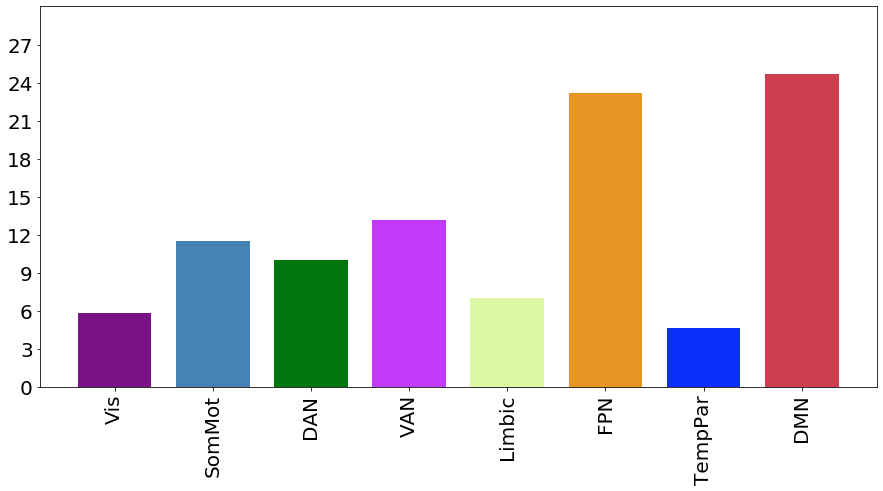

In [252]:
ind = 0
barwidth = 0.75 # width of individual bars

fig, ax = plt.subplots(figsize =(15,7))
# ax = fig.gca()
visbars = ax.bar(ind, engaged_ntwx[0], barwidth, color = '#781286',align = 'center')
sommotbars = ax.bar(ind+1,engaged_ntwx[1],barwidth, color = '#4682B4',align = 'center')
dorsattnbars = ax.bar(ind+2,engaged_ntwx[2], barwidth, color = '#00760E',align = 'center')
ventattnbars = ax.bar(ind+3, engaged_ntwx[3], barwidth, color = '#C43AFA',align = 'center')
limbicbars = ax.bar(ind+4, engaged_ntwx[4], barwidth, color = '#DCF8A4',align = 'center')
fpnbars = ax.bar(ind+5, engaged_ntwx[5], barwidth, color = '#E69422',align = 'center')
tempparbars = ax.bar(ind+6, engaged_ntwx[7], barwidth, color = '#0C30F9',align = 'center')
dmnbars = ax.bar(ind+7, engaged_ntwx[6], barwidth, color = '#CD3E4E',align = 'center')
# ax.bar(x_axis, engaged_ntwx, width, align = 'center')
ax.set_ylim([0, 30])
plt.yticks(np.arange(0,30,3),fontsize=20)
ax.set_xticklabels(['blah','Vis', 'SomMot', 'DAN', 'VAN', 'Limbic', 'FPN', 'TempPar', 'DMN'],size='20', rotation=90)#,ha="centre")

plt.show()



## ---------------------------------------------------------------------------------------------------------------------------------

### Using Brain Connectivity toolbox

Use bct to get node degree

In [53]:
import bct as bct

In [62]:
_test = og_data_all_subs2[0].model.gains_con.detach().numpy()

In [64]:
_test


array([[-0.96989673,  6.2085447 ,  1.6280998 , ..., -1.9107496 ,
        -3.346268  , -3.1725242 ],
       [ 6.208546  , -1.0023162 ,  6.3453803 , ...,  4.5043206 ,
        -3.5495129 , -3.3946154 ],
       [ 1.6281    ,  6.345379  , -0.98581016, ..., -2.2025473 ,
        -3.7083638 , -3.3429513 ],
       ...,
       [-1.9107496 ,  4.5043197 , -2.2025476 , ..., -0.9746916 ,
         0.04179398,  1.1136295 ],
       [-3.346268  , -3.5495129 , -3.7083642 , ...,  0.041794  ,
        -0.99071145,  1.7619112 ],
       [-3.1725242 , -3.3946154 , -3.3429513 , ...,  1.1136295 ,
         1.7619114 , -0.966467  ]], dtype=float32)

In [69]:
array_ones = np.ones((200, 200))

In [74]:
array_ones

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [72]:
bct_node_degree = bct.degree(array_ones)

TypeError: 'module' object is not callable

In [60]:
type(og_data_all_subs2[0].model.gains_con.detach().numpy())

numpy.ndarray

In [83]:
bct.degree??

In [76]:
from bct.utils import binarize

In [78]:
binarize?

In [79]:
_test2 = binarize(_test)

In [82]:
bct_node_degree = bct.degree(_test2)

TypeError: 'module' object is not callable